# Basic Perceptron

The perceptron is a linear classifier. It's relatively easy to understand and, given the right circumstances, converges really fast. We'll use 2-dimensional data to illustrate how it works.

## Linearly separable data

The perceptron is guaranteed to converge if the data is linearly separable - that is, you can draw a line that divides the plane into 2 sections such that all the points belonging to class A end up on one side of the line, and class B on the other.

It's a bit of a contrived example given how difficult it can be to find 'real' data that can be separated linearly. There are techniques to assist with that (such as projecting the points in such a way that they do become separable) but we won't cover that here.

Let's start by generating a number of coordinates on the back of 2 normal distributions. Note that I picked a seed (and the mean/variance of each distribution) in such a way that the data *is* linearly separable. If you change those parameters you can easily find yourself with one that isn't.

If you're not convinced (visually, at least), you can derive the convex hulls for each class and if they do not overlap, youre' good to.

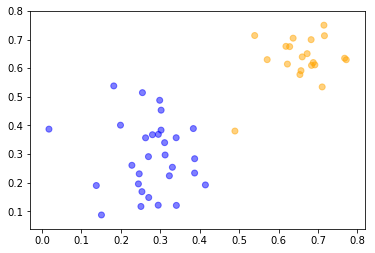

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy, pandas
numpy.random.seed(19991225)
numPointsA = 30
numPointsB = 20
clusterA = {'loc': 0.3, 'scale': 0.1}
clusterB = {'loc': 0.65, 'scale': 0.08}

pointsA = numpy.random.normal(size=2*numPointsA, **clusterA)
pointsB = numpy.random.normal(size=2*numPointsB, **clusterB)

dfA = pandas.DataFrame(list(zip(*numpy.reshape(pointsA, (2,numPointsA)))), columns=['x','y'])
dfB = pandas.DataFrame(list(zip(*numpy.reshape(pointsB, (2,numPointsB)))), columns=['x','y'])
df = pandas.concat([dfA,dfB])
df['colour'] = ['blue']*numPointsA + ['orange']*numPointsB
df['class'] = [-1]*numPointsA + [1]*numPointsB
plt.scatter(df.x,df.y, c=df.colour, alpha=0.5)

## The perceptron in principle

In a nutshell, the perceptron will find a decision boundary which, in 2D, is a line. Anything on either side of that boundary belongs to the same class.

So how does it work? If you recall a line can be described as $y = mx+b$. We can rewrite this as $0= mx+b-y$. The perceptron learning algorithm (PLA) works by finding the parameters $m$ and $b$ (technically the parameters from which $m$ and $b$ can be derived) such that for every $x_A,y_A$ in class A, $mx_A+b-y_A > 0$ and for every $x_B,y_B$ in class B, $mx_B+b-y_B < 0$.

We start by defining a series of weights, $w_0,w_1,w_2$. For every point in our dataset we calculate the sign of $w_01+w_1x+w_2y$ - that is, whether it's positive or negative. The first weight, $w_0$, is what we call the bias. If it didn't exist it would imply that our line would always go through the origin, and would be akin to having $b$ equal to 0.

If a point is misclassified - such as the output being positive when the class is `-1`, the perceptron will update its weights to bring the line 'closer' to the misclassified point. It doesn't mean it will be properly classified next time but it should be closer. If a point is correctly classified, the weights aren't adjusted.

This is repeated until every point is correctly classified or we have reached a certain number of iterations. Recall that if the data isn't linearly separable it will never converge - so this is necessary to ensure we don't loop to infinity (and beyond!).

## The perceptron in practice

Let's write this out in Python. You'll note a `learning_rate` variable. It's not particularly useful in this example but helps to control how fast the algorithm tries to adjust the weights.

The last call to `plt.plot` might look a bit weird but essentially gives two points through which the line passes. Recall the boundary is $w_0+w_1x+w_2y=0$, which we can rewrite as $x=-\frac{w_0+w_2y}{w_1}$. We arbitrarily pick 2 $y$ coordinates and draw the corresponding line.

True 6 0


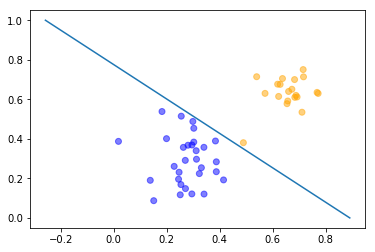

In [21]:
weights = [0,0,0]
threshold = 0.1
max_iterations = 100
num_iter = 0
has_converged = False
learning_rate = 0.01
while (not has_converged) and (num_iter < max_iterations):
    total_error = 0
    for _, row in df.iterrows():
        bias = 1
        x,y,cl = row['x'], row['y'], row['class']
        v = [bias,x,y]
        outcome = 1 if numpy.inner(weights,v) > 0 else -1
        error = cl - outcome
        total_error += numpy.absolute(error)
        weights[0] += error*learning_rate
        weights[1] += error*learning_rate*x
        weights[2] += error*learning_rate*y
    num_iter += 1
    if total_error < threshold:
        has_converged = True
print(has_converged, num_iter, total_error)

plt.scatter(df.x,df.y,c=df.colour,alpha=0.5)
w0, w1, w2 = weights
plt.plot(((-w0-w2*ymin)/w1, (-w0-w2*ymax)/w1),(ymin,ymax))

We managed to find *a* boundary with 0 misclassifications, in only 6 iterations!

## Using `sklearn`

Now that we understand how this works, we can leverage `sklearn` and do this in a handful of lines.

accuracy: 1.0
[[ 1.35712184  0.92033786]]
[-1.]


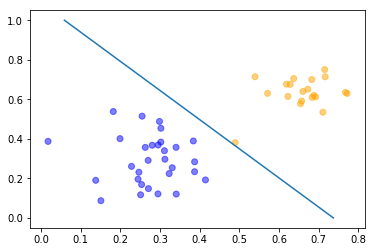

In [22]:
import sklearn.linear_model
perc = sklearn.linear_model.Perceptron()
perc.fit(df[['x','y']], df['class'])

print('accuracy:', perc.score(df[['x','y']],df['class']))
print(perc.coef_)
print(perc.intercept_)

ymin, ymax = plt.ylim()
w1,w2 = perc.coef_[0]
w0 = perc.intercept_[0]

plt.plot(((-w0-w2*ymin)/w1, (-w0-w2*ymax)/w1),(ymin,ymax))
plt.scatter(df.x,df.y,c=df.colour, alpha=0.5)
# you can also plot the boundary with the below, which is taken straight from sklearn's documentation
#w = perc.coef_[0]
#a = -w[0]/w[1]
#xx = numpy.linspace(ymin,ymax)
#yy = a*xx-w0/w2
#plt.plot(xx,yy)

## Conclusion

The decision boundary isn't unique - there is an infinite number of them. But our own implementation lines up pretty well with the `sklearn`'s.
